<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Подбор-модели" data-toc-modified-id="Подбор-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подбор модели</a></span><ul class="toc-item"><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Подбор-параметров" data-toc-modified-id="Подбор-параметров-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подбор параметров</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li><li><span><a href="#Ансамблирование-моделей" data-toc-modified-id="Ансамблирование-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Ансамблирование моделей</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем необходимые библиотеки и посмотрим данные.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('/datasets/Churn.csv', index_col="RowNumber")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Есть пропуски в столбце Tenure

In [4]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.duplicated().sum()

0

Явных дубликатов не найдено.

In [6]:
data = data.drop(['Surname', 'CustomerId'], axis=1)

Столбцы с ID и фамилией нам не понадобятся для построения модели, их можно удалить.

In [7]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Видна большая разница в масштабах численных признаков. В зависимости от выбранного алгоритма может понадобиться скалирование.

In [8]:
for c in ['Gender', 'Geography', 'Exited']:
    display(data[c].value_counts())

Male      5457
Female    4543
Name: Gender, dtype: int64

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

0    7963
1    2037
Name: Exited, dtype: int64

Неявных дубликатов в категориальных признаках нет. Есть дисбаланс в целевом признаке.

In [9]:
data[data['Tenure']==0].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,382.000000,382.000000,382.0,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,651.913613,39.306283,0.0,80135.307277,1.437173,0.651832,0.531414,99565.395157,0.235602
std,95.741781,10.418181,0.0,62233.212461,0.522442,0.477014,0.499667,57360.554103,0.424931
min,350.000000,19.000000,0.0,0.000000,1.000000,0.000000,0.000000,332.810000,0.000000
25%,592.250000,32.000000,0.0,0.000000,1.000000,0.000000,0.000000,47574.687500,0.000000
50%,653.000000,38.000000,0.0,101050.445000,1.000000,1.000000,1.000000,102160.510000,0.000000
75%,714.750000,44.750000,0.0,129638.762500,2.000000,1.000000,1.000000,149577.825000,0.000000
max,850.000000,79.000000,0.0,197041.800000,3.000000,1.000000,1.000000,199478.050000,1.000000


In [10]:
data[data['Tenure'].isna()].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


Заполним пропуски случайными значениями из имеющейся выборки.

In [11]:
data['Tenure'].fillna(
    pd.Series(
        np.random.choice(data[data['Tenure'].notna()]['Tenure'], data.shape[0]),
        index=data.index),
    inplace=True)


Разобьем выборку на учебную, валидационную и тестовую.

In [12]:
def y_extract(data, y_name):
    target = data[y_name]
    features = data.drop(y_name, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state = 666) # выделим из выборки тестовую
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .25, random_state = 666) # а учебную разобьем на, собственно, учебную и валидационную
    for d in (X_train, X_valid, X_test, y_train, y_valid, y_test):
        d.reset_index(drop=True, inplace=True)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [13]:
X_train, X_valid, X_test, y_train, y_valid, y_test = y_extract(data, 'Exited')
X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(6000, 2000, 2000)

Для отправки в модель нужно перекодировать текстовые категориальные признаки.

In [14]:
def encoding (data, col_names, encoder):
    return pd.concat([data.drop(data[col_names], axis = 1), # объединим дату без строковых признаков
                      pd.DataFrame(encoder.transform(data[col_names]), columns = col_names)], # с перекодированными признаками
                     axis=1)

In [15]:
encoder = OrdinalEncoder() #создадим экземпляр энкодера
encoder.fit(X_train[['Geography', 'Gender']]) # и обучим его на train выборке
X_train = encoding(X_train, ['Geography', 'Gender'], encoder)
X_valid = encoding(X_valid, ['Geography', 'Gender'], encoder)
X_test = encoding(X_test, ['Geography', 'Gender'], encoder)

**Выводы**

Мы рассмотрели данные и подготовили их к задаче классификации

## Исследование задачи

За основу возьмем алгоритм случайного леса.

In [16]:
model = RandomForestClassifier(n_estimators = 40, max_depth = 10, random_state = 666)

In [17]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=666,
                       verbose=0, warm_start=False)

Проверим метрики на валидационной выборке.

In [18]:
pred_p = model.predict_proba(X_valid)[:,1]
pred = model.predict(X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred_p))

              precision    recall  f1-score   support

  Not exited       0.87      0.97      0.92      1588
      Exited       0.82      0.43      0.57       412

    accuracy                           0.86      2000
   macro avg       0.84      0.70      0.74      2000
weighted avg       0.86      0.86      0.85      2000

ROC-AUC: 0.8467144359394488


**Выводы**

Реколл по объектам с целевым классом значительно ниже. Это значит, что наша модель будет пропускать 60% клиентов, которые собираются уйти. Ошибка первого рода для наших целей критичнее, т.к. удержать клиента дешевле, чем найти нового. Необходимо сбалансировать учебную классы для дальнейшего обучения модели.

## Подбор модели

### Борьба с дисбалансом

Рассмотрим несколько способов борьбы с дисбалансом:
1. Взвешивание классов
2. Увеличение выборки
3. Изменение порога классификации

Напишем функцию для выравнивания баланса классов по количеству объектов.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=666)
    
    return features_upsampled, target_upsampled

Создадим увеличенные выборки для обучения

In [20]:
repeat = np.floor(y_train.value_counts()[0]/y_train.value_counts()[1]).astype(int)
X_upsampled, y_upsampled = upsample(X_train, y_train, repeat)

In [21]:
y_upsampled.value_counts()

0    4768
1    3696
Name: Exited, dtype: int64

Теперь дисбаланс не такой сильный, можно перейти к обучению моделей и сравнению способов.

In [22]:
model = RandomForestClassifier(n_estimators = 40, # создадим модель со взвешиванием классов
                               max_depth = 10, 
                               class_weight='balanced', 
                               random_state = 666)
model_upsample = RandomForestClassifier(n_estimators = 40,  # модель для обучения на увеличенной выборке
                                        max_depth = 10, 
                                        random_state = 666)
model_thrshld_moving = RandomForestClassifier(n_estimators = 40,  # модель для которой будем подбирать порог классификации
                                        max_depth = 10, 
                                        random_state = 666)

In [23]:
model.fit(X_train, y_train)
model_upsample.fit(X_upsampled, y_upsampled)
model_thrshld_moving.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=666,
                       verbose=0, warm_start=False)

Посмотрим на показатели.

In [24]:
pred_p = model.predict_proba(X_valid)[:,1]
pred = model.predict(X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred_p))

              precision    recall  f1-score   support

  Not exited       0.90      0.89      0.89      1588
      Exited       0.59      0.61      0.60       412

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000

ROC-AUC: 0.8492394414418821


In [25]:
pred_p = model_upsample.predict_proba(X_valid)[:,1]
pred = model_upsample.predict(X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred_p))

              precision    recall  f1-score   support

  Not exited       0.90      0.88      0.89      1588
      Exited       0.58      0.61      0.59       412

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000

ROC-AUC: 0.8489635555501212


In [26]:
def probs_to_class(probs, threshold): # классификация по нестандартному порогу
    return (probs >= threshold).astype('int')

In [27]:
probs = model_thrshld_moving.predict_proba(X_valid)[:, 1] # сохраним значения вероятностей для целевого класса
thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(y_valid, probs_to_class(probs, t)) for t in thresholds] # и посчитаем ф-значение для каждого порога
ind = np.argmax(scores) # получим индекс максимальной метрики
pred = probs_to_class(probs, thresholds[ind]) # сформируем предикты по лучшему показателю порога
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )

              precision    recall  f1-score   support

  Not exited       0.89      0.91      0.90      1588
      Exited       0.63      0.58      0.61       412

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.84      0.84      0.84      2000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Лучшие показатели у модели с балансированием целевого признака увеличением выборки.

### Подбор параметров

С помощью SelectKBest определим все ли признаки нам нужны для построения модели. Здесь и далее в качестве обучающей выборки будем использовать сбалансированную увеличением количества объектов

In [28]:
scores = []
for k in range(1, 11):
    selector = SelectKBest(f_classif, k=k).fit(X_upsampled, y_upsampled)
    model_upsample.fit(selector.transform(X_upsampled), y_upsampled) 
    scores.append(f1_score(y_valid, model_upsample.predict(selector.transform(X_valid))))
print(pd.Series(scores))

0    0.507903
1    0.495595
2    0.489192
3    0.491620
4    0.592342
5    0.594406
6    0.587544
7    0.593640
8    0.588785
9    0.594340
dtype: float64


Лучший результат достигнут при использовании всех признаков

### Подбор гиперпараметров

Для подбора параметров к случайному лесу ограничим некоторые параметры во избежания переобучения.

In [29]:
params={
    'n_estimators': [1, 40], 
    'max_depth': [1, 10],
    'min_samples_split': [10, 20], 
    'min_samples_leaf': [3, 10]
}

Найдем параметры при помощи гридсерча

In [30]:
gs = GridSearchCV(model, params)
_ = gs.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Сохраним полученную модель

In [31]:
model_gs = gs.best_estimator_

Попробуем также подобрать гиперпараметры путем перебора.

In [32]:
res=[]

In [33]:
def gpsearch(kw, p, s, r):
    kwarg = kw.copy()
    param = p.copy()
    score = s
    results=r
    for t_param in param: # переберем все параметры поочереди
        values = param[t_param] # получим диапазон значений для проверки
        param.pop(t_param) # удалим параметр для передачи усеченного списка во вложенный цикл
        for v in range(values[0], values[1]+1):
            kwarg[t_param] = v # сохраняем очередное значение текущего атрибута
            if len(param)>0: # если запущены циклы не по всем параметрам, то рекурсивно вызываем функцию
                kwarg, score = gpsearch(kwarg, param, score, results)
            else:
                mod = RandomForestClassifier(random_state=666, **kwarg)
                mod.fit(X_upsampled, y_upsampled)
                t_score = f1_score(y_valid, mod.predict(X_valid))
                if t_score > score:
                    score = t_score
                    t_kwarg=kwarg.values()
                    print(t_kwarg, score)
                    results.append([t_kwarg, score])
        kwarg[t_param]=values[0]
        return kwarg, score

In [34]:
#%%time
#score=0
#gpsearch({}, params, score, res)
'''
dict_values([1, 1, 10, 3]) 0.38095238095238093
dict_values([1, 2, 10, 3]) 0.5137085137085137
dict_values([1, 3, 10, 3]) 0.522167487684729
dict_values([1, 5, 10, 3]) 0.577639751552795
dict_values([1, 5, 10, 5]) 0.578838174273859
dict_values([2, 5, 10, 8]) 0.5899280575539569
dict_values([3, 8, 10, 9]) 0.5966850828729282
dict_values([3, 8, 19, 9]) 0.6037735849056604
dict_values([6, 8, 11, 5]) 0.6061899679829242
dict_values([6, 8, 14, 3]) 0.6131549609810479
dict_values([6, 8, 19, 8]) 0.6134831460674157
dict_values([9, 8, 12, 4]) 0.6146788990825689
dict_values([19, 10, 12, 3]) 0.6150289017341041
dict_values([37, 8, 19, 9]) 0.6166097838452788
dict_values([38, 8, 19, 9]) 0.6181818181818183
CPU times: user 1h 35min 32s, sys: 15.4 s, total: 1h 35min 48s
Wall time: 1h 37min 23s
'''

'\ndict_values([1, 1, 10, 3]) 0.38095238095238093\ndict_values([1, 2, 10, 3]) 0.5137085137085137\ndict_values([1, 3, 10, 3]) 0.522167487684729\ndict_values([1, 5, 10, 3]) 0.577639751552795\ndict_values([1, 5, 10, 5]) 0.578838174273859\ndict_values([2, 5, 10, 8]) 0.5899280575539569\ndict_values([3, 8, 10, 9]) 0.5966850828729282\ndict_values([3, 8, 19, 9]) 0.6037735849056604\ndict_values([6, 8, 11, 5]) 0.6061899679829242\ndict_values([6, 8, 14, 3]) 0.6131549609810479\ndict_values([6, 8, 19, 8]) 0.6134831460674157\ndict_values([9, 8, 12, 4]) 0.6146788990825689\ndict_values([19, 10, 12, 3]) 0.6150289017341041\ndict_values([37, 8, 19, 9]) 0.6166097838452788\ndict_values([38, 8, 19, 9]) 0.6181818181818183\nCPU times: user 1h 35min 32s, sys: 15.4 s, total: 1h 35min 48s\nWall time: 1h 37min 23s\n'

Сохраним 5 лучших моделей для дальнейшего ансамблирования

In [35]:
kwargs = []
# почему то сохраненные в res значения не совпадают с выведенными принтом, записал значения руками
#for r in res[-5:]: 
#    kwargs.append(dict(zip(params, r[0])))
    
kwargs.append({'n_estimators': 38, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 9})
kwargs.append({'n_estimators': 37, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 9})
kwargs.append({'n_estimators': 19, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 3})
kwargs.append({'n_estimators': 9, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 4})
kwargs.append({'n_estimators': 6, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 8})


In [36]:
models = []
for i in range(len(kwargs)):
    models.append(RandomForestClassifier(random_state=666, **kwargs[i]))
_ = models[0].fit(X_upsampled, y_upsampled)

Сравним лучшие модели от гридсерча и ручного подбора

In [37]:
pred_p = model_gs.predict_proba(X_valid)[:,1]
pred = model_gs.predict(X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred_p))

              precision    recall  f1-score   support

  Not exited       0.90      0.88      0.89      1588
      Exited       0.57      0.63      0.60       412

    accuracy                           0.83      2000
   macro avg       0.74      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000

ROC-AUC: 0.8533173558973858


In [38]:
pred_p = models[0].predict_proba(X_valid)[:,1]
pred = models[0].predict(X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred_p))

              precision    recall  f1-score   support

  Not exited       0.90      0.88      0.89      1588
      Exited       0.57      0.64      0.60       412

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.83      0.83      0.83      2000

ROC-AUC: 0.8530636325841873


### Ансамблирование моделей

Попробуем заансамблировать полученные модели и посмотрим как это повлияет на метрики.

In [39]:
def stack(models, X, y, random, proba=False):
    meta_data = pd.DataFrame([])
    strats = StratifiedKFold(n_splits = 10,random_state = random) # разобьем учебные данные на части для кроссвалидации
    for m in models:
        result_train = np.empty((0,1),float)
        for train_i,target_i in strats.split(X,y): # поочередно получим индексы пар выборок
            x_train,x_val=X.iloc[train_i],X.iloc[target_i] # и на основе полученных индексов сформируем учебные выборки
            y_train,y_val=y.iloc[train_i],y.iloc[target_i] # и ответы для них
            m.fit(x_train, y_train) # обучим модель
            if proba:
                result_train = np.append(result_train, m.predict_proba(x_val)[:, 1])
            else:
                result_train = np.append(result_train, m.predict(x_val))
            m.fit(X, y) # <======Тут добавил
        meta_data = pd.concat([meta_data,pd.Series(result_train)], axis=1)
    return meta_data

In [40]:
def metamodel_predict(model, models, X, proba = False):
    meta_data = pd.DataFrame([])
    for m in models:
        if proba:
            meta_data = pd.concat([meta_data,pd.Series(m.predict_proba(X)[:, 1])], axis=1)
        else:
            meta_data = pd.concat([meta_data,pd.Series(m.predict(X))], axis=1)
    return model.predict(meta_data)

In [41]:
result_train = stack(models, X_upsampled, y_upsampled, 666)

In [42]:
_ = model.fit(result_train, y_upsampled)

Попробуем посмотреть на результаты стакинга с обычным придиктом и вероятностным

In [43]:
pred = metamodel_predict(model, models, X_valid)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )

              precision    recall  f1-score   support

  Not exited       0.90      0.85      0.88      1588
      Exited       0.53      0.65      0.58       412

    accuracy                           0.81      2000
   macro avg       0.72      0.75      0.73      2000
weighted avg       0.83      0.81      0.82      2000



In [44]:
result_train = stack(models, X_upsampled, y_upsampled, 666, True)
model.fit(result_train, y_upsampled)
pred = metamodel_predict(model, models, X_valid, True)
print(classification_report(y_valid, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_valid, pred))

              precision    recall  f1-score   support

  Not exited       0.90      0.83      0.86      1588
      Exited       0.50      0.67      0.57       412

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.82      0.79      0.80      2000

ROC-AUC: 0.745937370081436


**Выводы**

Стакинг не показал ожидаемого результата. Напротив: ухудшил метрики. Вероятно это связано с используемыми моделями, которые уже сами являются отобранными на валидационной выборке ансамблями.
По итогу лучшие показатели дала модель с сбалансированной выборкой путем увеличения количества объектов, использованием всех доступных параметров и ручным подбором гиперпараметров.

## Тестирование модели

Запустим в итоговую модель тестовую выборку.

In [45]:
pred = models[0].predict(X_test)
print(classification_report(y_test, pred, target_names=['Not exited', 'Exited']) )
print('ROC-AUC:', roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

  Not exited       0.92      0.88      0.90      1607
      Exited       0.57      0.67      0.62       393

    accuracy                           0.84      2000
   macro avg       0.74      0.77      0.76      2000
weighted avg       0.85      0.84      0.84      2000

ROC-AUC: 0.7736223994578427


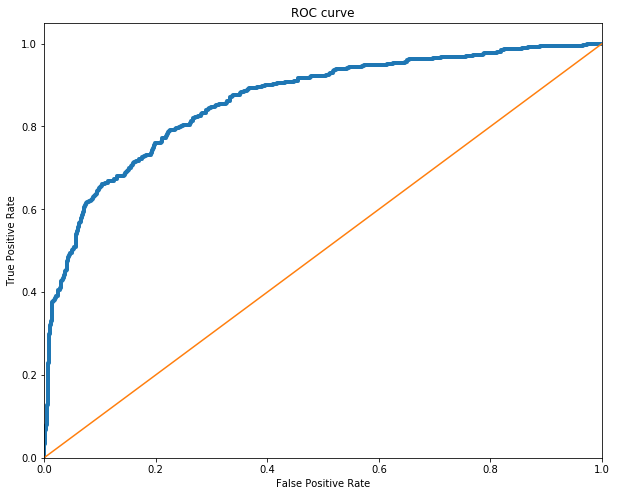

In [46]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, models[0].predict_proba(X_test)[:,1], pos_label=1)
lw = 4
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

**Выводы**

На тестовой выборке обученная модель показала как неплохое f-значение, так и лучшее значение реколл, чем любые другие модели на валидационной выборке.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*